---
# PGA 2025 Practical 6:
# Discordance, gene flow and ABBA BABA
---

This practical consists of two parts:
* A **learning** part that includes class discussions and 8 excercise.
* An **assessed** part consisting of 7 exercises

At the end of learning part you should

* Understand how and why the shape (topology) of genealogies changes along the genome
    * The concept of incomplete lineage sorting
    * The effect of population size and split time on discordance
    * The effect of gene flow on discordance


* Know how to perform and analyse multiple-population simulations
    * Defining simulation models
    * Analysing tree sequences and genealogy shapes


* Understand how mutation patterns ("ABBA" and "BABA") provide evidence for gene flow
    * Write python functions to compute these summaries
    * Understand the difference between the *D* statistic and the proportion of introgression *f*


### Preparation

Download the folder containing data files necessary for this project and unzip.
This may take a few minutes because it's a big dataset.
Note these commands start with the `!` symbol because they are bash commands.

In [ ]:
#download
!wget --no-check-certificate 'https://www.dropbox.com/scl/fi/2fziv3qlk83ufy6wpssb5/Prac6_data_2024.zip?rlkey=bx3mj62edf7uyjp199j83j5np&dl=0' -q -O Prac6_data_2024.zip

#unzip
!unzip Prac6_data_2024.zip

Import the necessary python packages.

In [1]:
import math
import msprime
import tskit
import demes
import demesdraw
import numpy as np
import allel
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import SVG, set_matplotlib_formats

---
# 1. Genealogical discordance

## 1.1 Tree topologies

To start thinking about the shape (topology) of genealogies, we will start with the simplest possible case, where we have just three leaves.

### 1.1.1 All possible topologies for a tree with three leaves

For a given set of tip labels, there is a limited number of tree topologies.

`tskit` provides the [`all_trees()`](https://tskit.dev/tskit/docs/stable/python-api.html?highlight=all_trees#tskit.all_trees) function to generates all possible tree topologies for a given number of leaves.

We want to give each topology a unique ID code so we can count how many times we see each one. We will use the [`rank()`](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.Tree.rank) function of `tskit` for this. Note that this tree ID code does not consider branch lengths, so all trees with the same **topology** (shape) will have the same ID.




Topology ID: (0, 0)
Newick format: (0,1,2);


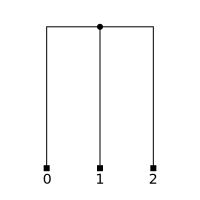



Topology ID: (1, 0)
Newick format: (0,(1,2));


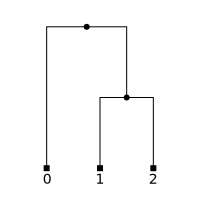



Topology ID: (1, 1)
Newick format: (1,(0,2));


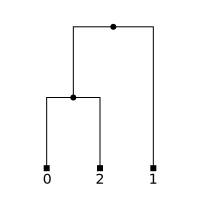



Topology ID: (1, 2)
Newick format: (2,(0,1));


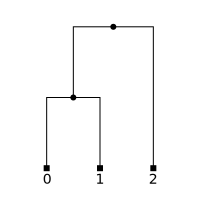

In [2]:
#generate all possible topologies and store as tskit tree objects
topos = tskit.all_trees(3)

#visualise and report the rank (unique ID code) of each tree topology
for t in topos:
    ID = t.rank()
    print("\n\nTopology ID:", ID)
    print("Newick format:", t.newick(node_labels={0: 0, 1: 1, 2: 2}, include_branch_lengths=False))
    display(SVG(t.draw(node_labels={0: 0, 1: 1, 2: 2})))

So there are **four** possible topologies for a tree with three leaves. The first one has a **multifurcation** (also called a polytomy) (>2 banches from a single node), the rest have only **bifurcations**.

The ID code returned by the `tree.rank()` function is always a tuple with two integers. in this case: `(0,0)`, `(1,0)`, `(1,1)` and `(1,2)`. The first value corresponds to the shape of the tree and the second to the order of the leaf labels.

**We will be using these ID codes below to identify the shape of each genealogy along the genome in simulated treesequences**, and thereby compare the **abundance** of different topologies.

Because the ID codes from `tskit` are not very easy to remember, we will create a dictionary that allows us to convert the ID code to a [newick format](https://en.wikipedia.org/wiki/Newick_format) tree.


In [3]:
#make an empty dictionary
treeID_to_nwk = {}

#for each tree, get the ID and the newick string and add to the dictionary
for t in tskit.all_trees(3):
    ID = t.rank()
    nwk_string = t.newick(node_labels={0: 0, 1: 1, 2: 2}, include_branch_lengths=False)
    treeID_to_nwk[ID]=nwk_string

#look at the dictionary to ensure it makes sense
treeID_to_nwk

{(0, 0): '(0,1,2);',
 (1, 0): '(0,(1,2));',
 (1, 1): '(1,(0,2));',
 (1, 2): '(2,(0,1));'}

Make sure you understand how newick format relates to the shape of a tree. For example, can you see how `(2,(0,1));` and `((0,1),2);` have the same topology?

Under standard coalescent theory, the probability of a multifurcation (more than two lineages coalesce in a single generation) is usually negligable. Therefore standard coalescent simulations only produce bifurcating trees. We will therefore not encounter the first topology `(0,1,2);` in this practical.

### 1.1.2 The probability of each topology in a bifurcating species tree

<div class="alert alert-block alert-info">
    <b>Popgen: Topology likelihoods</b> 
    
In Lecture 6 we saw that, under a **species tree** with topology `(2,(0,1))`, the likelihood of the three topologies **for genealogies** are: 

$$Pr[(2,(0,1))] = \frac{1}{3} e^{-t/2N} + (1-e^{-t/2N}) $$

$$Pr[(1,(0,2))] = \frac{1}{3} e^{-t/2N} $$

$$Pr[(0,(1,2))] = \frac{1}{3} e^{-t/2N} $$


Where $t$ refers to the length of the branch ancestral to poulations 0 and 1, and $N$ the effective population size of this population.

Thus, we always expect the species topology `(2,(0,1))` to be as common or more common than each of the two discordant topologies (<b>in the absence of gene flow</b>).
    </div>

## 1.2 Simulations

Now we will test our understanding of discordant genealogies using simulations.

### 1.2.1 Setting up the demographic model

We will run coalescent simulations in `msprime`. This allows any number of samples and complex demographic histories.

Our underlying model has three populations (or species) with the relationship ((X, Y), Z).

Branches in a **species tree** represent populations. To set up a species tree, we need to know how many populations existed in each time period (also called an epoch). Ours has the following branches:
- 3 branches in the present day: X, Y and Z
- 1 'internal' branch, ancestral to X and Y
- 1 'ancestral' branch ancestral to X, Y and Z
- 2 split times:
    - The time at which the ancestor of X and Y splits to produce X and Y
    - The time at which the deep ancestor splits to produce Z and the XY ancestor

To simplify setting up the demographic model, we will use the package [`demes`](https://popsim-consortium.github.io/demes-docs/latest/introduction.html).

Our model is generated ***inside*** **a python function**, which returns a [`demes.Graph`](https://popsim-consortium.github.io/demes-docs/latest/api.html#working-with-demes-graphs) object. This is a useful way to set up a simulation model if you intend to run it multiple times and modify parameters. Our function will allow us to set the sizes of each of the populations, and the split times.


In [4]:
#demographic model. Tree has shape ((X,Y),Z))
def three_pop_model(N_X=1e4, N_Y=1e4, N_Z=1e4,     #population sizes of X, Y and Z
                    N_XY=1e4, N_XYZ=1e4,           #population sizes for ancestral populations
                    t_XY=2e4, t_XYZ=4e4):         #split times
    
    #Make a 'deme builder' object to set up the demographic history
    b = demes.Builder(time_units="generations")
    #add the branches IN ORDER from the past to the present
    b.add_deme("XYZanc",                      epochs=[{"start_size":N_XYZ, "end_time":t_XYZ}])
    b.add_deme("XYanc", ancestors=["XYZanc"], epochs=[{"start_size":N_XY,  "end_time":t_XY}])
    b.add_deme("X",     ancestors=["XYanc"],  epochs=[{"start_size":N_X}])
    b.add_deme("Y",     ancestors=["XYanc"],  epochs=[{"start_size":N_Y}])
    b.add_deme("Z",     ancestors=["XYZanc"], epochs=[{"start_size":N_Z}])
    
    graph = b.resolve()
    
    return(graph)

Note that running the code in the above cell does not produce an output. It just saves the function, ready for us to use whenever we need it below.

We can call our function to generate a model graph object, and we can then make a pretty visualisation of this using the [`tubes()`](https://grahamgower.github.io/demesdraw/latest/quickstart.html#demes-as-tubes) function of `demesdraw`.

<AxesSubplot:title={'center':'Three population model'}, ylabel='time ago (generations)'>

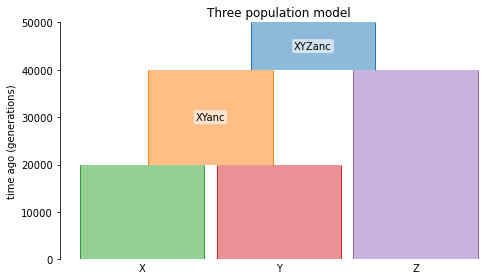

In [5]:
#Save the demographic model as a demes.Graph object.
model_graph = three_pop_model()

#Check that the model we have defined looks right using the demesdraw tool
demesdraw.tubes(model_graph, title = "Three population model")

Given the formulae above, we can calculate the expected frequency of genealogies with the species tree topology and the discordant topologies given the parameters of our model. Ne was set to 10,000 (and we will assume **haploid** individuals) and the length of the internal branch was 20,000 generations.

In [6]:
freq_species = (1/3)*math.e**(-20000/10000) + (1 - math.e**(-20000/10000))
freq_discordant = (1/3)*math.e**(-20000/10000)

print(f"The expected frequency of genealogies with the species topology is {freq_species}")

print(f"The expected frequency of genealogies with each discordant topology is {freq_discordant}")

The expected frequency of genealogies with the species topology is 0.9097764778422582
The expected frequency of genealogies with each discordant topology is 0.045111761078870896


### 1.2.2 Simulating a treesequence

Now we simulate our first treesequence. We will assume a 10 million bp region of the genome, with a recombination rate of 2e-8. Note that we have to tell msprime to use the demographic model graph that we made.

In [7]:
#simulate a treesequence with three haploid individuals
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},      #tell msprime to sample one individual from each population
                          demography = msprime.Demography.from_demes(model_graph), #tell msprime to use the demographic model we created
                          sequence_length = 10e6, recombination_rate = 2e-8, ploidy=1, random_seed=123) #other simulation parameters

print(f"This treesequence has {ts.num_trees} trees.")

This treesequence has 9524 trees.


We can take a look at the first tree to confirm we have just three leaves

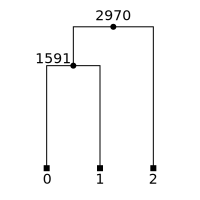

In [8]:
SVG(ts.first().draw_svg())

A treesequence simulated in msprime carries information about which population each individual was sampled from. We can therefore check to confirm that `0` comes from population `X`, `1` from population `Y` and `2` from `Z`.

In [9]:
for s in ts.samples():
    pop_number = ts.get_population(s)
    pop_name = ts.populations()[pop_number].metadata["name"]
    print(f"Sample {s} is from population {pop_number}, which is named {pop_name}.")

Sample 0 is from population 2, which is named X.
Sample 1 is from population 3, which is named Y.
Sample 2 is from population 4, which is named Z.


Note that each population has a number as well as a 'name', which we gave it in the simulation. The population *number* depends on the *order* in which they appear in the demographic model, whereas the **name** is **defined by us** in the demographic model.

## 1.3 The abundance of different topologies in a treesequence

Now we would like to know how many of the genealogies along our treesequence represent each of the three possible topologies:

`(2,(0,1))` = `((X,Y),Z)` is the **species tree** topology.

`(1,(0,2))` = `((X,Z),Y)` **is discordant** with the species tree topology.

`(0,(1,2))` = `((Y,Z),X)` **is discordant** with the species tree topology.


### 1.3.1 Counting topologies in the treesequence

We will iterate over the treesequence and for each topology, we get its ID (using the `rank()` function), convert it to newick format for convenience, and then add it to the appropriate list.


In [10]:
#a dictionary to record which trees correspond to each topology
topo_matches = {'(2,(0,1));':[],
                '(1,(0,2));':[],
                '(0,(1,2));':[]}

# for each tree, we add its index to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    nwk_string = treeID_to_nwk[tree.rank()] #convert the tree's rank to a newick string
    topo_matches[nwk_string].append(i) #record this tree in the dictionary

#Print the number of each topology type
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    n = len(topo_matches[nwk_string])
    print(f"\nThere are {n} trees with topology {nwk_string}.")


There are 8419 trees with topology (2,(0,1));.

There are 551 trees with topology (1,(0,2));.

There are 554 trees with topology (0,(1,2));.


<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b>  

Use python code to compute the proportion of trees that match each of the three topologies. Do these match our expectations?
    

<b>Hint:</b> The total number of trees in the treesequence can be retrieved with (`ts.num_trees`).
    </div>

In [11]:
#SOLUTION:
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    proportion_of_trees = len(topo_matches[nwk_string])/ts.num_trees
    print(f"\nThe proportion of trees with topology {nwk_string} is {proportion_of_trees}")


The proportion of trees with topology (2,(0,1)); is 0.8839773204535909

The proportion of trees with topology (1,(0,2)); is 0.05785384292314154

The proportion of trees with topology (0,(1,2)); is 0.058168836623267536


### 1.3.2 The proportion of the genome that is discordant

It is important to note that the proportion of discordant genealogies is **not** the same as the **proportion of the genome that is discordant with the species tree.**

You will recall from Practical 3 that the lengths (or spans) of tracts with different genealogies are not all equal, so to calculate the total length of genome with a given topology, we need to sum the **spans** of all the corresponding trees.

We use a similar approach to above, using a python dictionary to store the span of each tree with each rank.

In [12]:
#a dictionary to record the tree spans each topology
tree_spans = {'(2,(0,1));':[],
              '(1,(0,2));':[],
              '(0,(1,2));':[]}

# for each tree, we add its span to the appropriate list based on its rank
for i,tree in enumerate(ts.trees()):
    nwk_string = treeID_to_nwk[tree.rank()]
    tree_spans[nwk_string].append(tree.span)

# Print the number of bp corresponding to each topology
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    total_span = sum(tree_spans[nwk_string])
    print(f"\nTrees with topology {nwk_string} total {total_span} bp.")


Trees with topology (2,(0,1)); total 9082411.0 bp.

Trees with topology (1,(0,2)); total 434988.0 bp.

Trees with topology (0,(1,2)); total 482601.0 bp.


<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b>
    
Use python code to retrieve the tree spans from the `tree_spans` dictionary and compute the **proportion** of the genome made up of discordant genealogies.

**Hint:** The total length of sequence can be retrieved using `ts.sequence_length`
    </div>

In [13]:
#SOLUTION
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    proportion_of_genome = sum(tree_spans[nwk_string])/ts.sequence_length
    print(f"\nThe proportion of genome with topology {nwk_string} is {proportion_of_genome}")


The proportion of genome with topology (2,(0,1)); is 0.9082411

The proportion of genome with topology (1,(0,2)); is 0.0434988

The proportion of genome with topology (0,(1,2)); is 0.0482601


<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>
    
Why do we see genealogies that are discordant with the species tree under which we ran our simulations?

Why is the proportion of the genome that is discordant lower than the proportion of *genealogies* that are discordant?
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b>  
Test the logic we have just discussed by calculating the mean span of each tree topology.

**Hint:** You can use the `np.mean()` function.
    </div>

In [14]:
#SOLUTION:
for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
    mean_span = np.mean(tree_spans[nwk_string])
    print(f"The average span of trees with topology {nwk_string} is {mean_span} bp")

The average span of trees with topology (2,(0,1)); is 1078.7992635704952 bp
The average span of trees with topology (1,(0,2)); is 789.4519056261342 bp
The average span of trees with topology (0,(1,2)); is 871.1209386281588 bp


<div class="alert alert-block alert-success">    
    <b>Exercise 4:</b>

Using code blocks from above, write a python **function** called `get_topology_proportions()`, which takes one input (`ts`) and prints the number of bp for each topology and the proportion of the genome that is discordant. Run the function to confirm that it works.
    </div>

In [15]:
#SOLUTION:
def get_topology_proportions(ts):
    
    #Make a dictionary to record the tree spans each topology
    tree_spans = {'(2,(0,1));':[],
                  '(1,(0,2));':[],
                  '(0,(1,2));':[]}
    
    # for each tree, we add its span to the appropriate list based on its rank
    for i,tree in enumerate(ts.trees()):
        nwk_string = treeID_to_nwk[tree.rank()]
        tree_spans[nwk_string].append(tree.span)
    
    #for each topology, get the sum of spans and divide by total sequence length, and print
    for nwk_string in ['(2,(0,1));', '(1,(0,2));', '(0,(1,2));']:
        print(f"\nThe proportion of genome with topology {nwk_string} is {sum(tree_spans[nwk_string])/ts.sequence_length}")

#test that the function works
get_topology_proportions(ts)


The proportion of genome with topology (2,(0,1)); is 0.9082411

The proportion of genome with topology (1,(0,2)); is 0.0434988

The proportion of genome with topology (0,(1,2)); is 0.0482601


---
# 2. Exploring factors that affect the extent of discordance

We have generated a pipeline to determine the proportion of the genome that is discordant under a given simulation model. We will now explore the effects of various modifications to the model to test theoretical predictions.

## 2.1 Factors that alter the extent of incomplete lineage sorting

### 2.1.1 Effect of population size


<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b>

What effect does **decreasing** or **increasing** the size of each population have on the proportion of discordant trees?

The code here is provided for you. All you need to do is change the population size parameter(s) in creating the model_graph object.
    </div>

This treesequence has 12688 trees.

The proportion of genome with topology (2,(0,1)); is 0.5546766

The proportion of genome with topology (1,(0,2)); is 0.2228099

The proportion of genome with topology (0,(1,2)); is 0.2225135


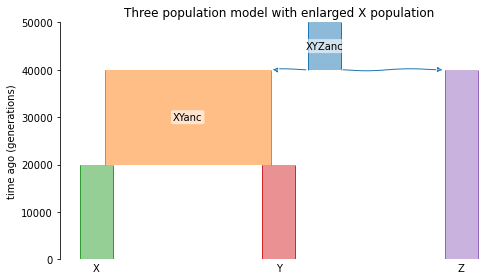

In [16]:
#Save the demographic model as a demes.Graph object.
model_graph = three_pop_model(N_XY=5e4)

#Check that the model we have defined looks right using the demesdraw tool
demesdraw.tubes(model_graph, title = "Three population model with enlarged X population")

#simulate a treesequence with three haploid individuals
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},      #tell msprime to sample one individual from each population
                          demography = msprime.Demography.from_demes(model_graph), #tell msprime to use the demographic model we created
                          sequence_length = 10e6, recombination_rate = 2e-8, ploidy=1, random_seed=123) #other simulation parameters

print(f"This treesequence has {ts.num_trees} trees.")

#compute proportions for each topology:
get_topology_proportions(ts)

#### Excercise 5 answer:

### 2.1.2 Effect of split times


<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b>
What effect does altering the split times have on the proportion of discordant trees, and why?

**Hint:** Copy the code given to you in exercise 5 as a starting point. Remember that we set default split times of `t_XY=2e4`, and `t_XYZ=4e4`.
    </div>

This treesequence has 8871 trees.

The proportion of genome with topology (2,(0,1)); is 0.9822483

The proportion of genome with topology (1,(0,2)); is 0.009969

The proportion of genome with topology (0,(1,2)); is 0.0077827


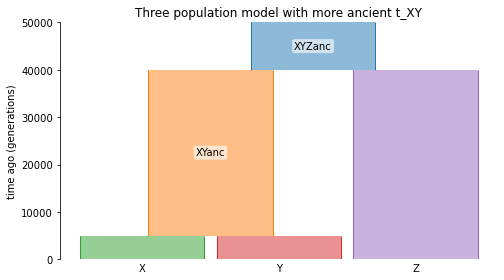

In [17]:
# SOLUTION:
#Save the demographic model as a demes.Graph object.
model_graph = three_pop_model(t_XY=0.5e4)

#Check that the model we have defined looks right using the demesdraw tool
demesdraw.tubes(model_graph, title = "Three population model with more ancient t_XY")

#simulate a treesequence with three haploid individuals
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},      #tell msprime to sample one individual from each population
                          demography = msprime.Demography.from_demes(model_graph), #tell msprime to use the demographic model we created
                          sequence_length = 10e6, recombination_rate = 2e-8, ploidy=1, random_seed=123) #other simulation parameters

print(f"This treesequence has {ts.num_trees} trees.")

#compute proportions for each topology:
get_topology_proportions(ts)

#### Exercise 6 answer:

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Which population size and which split times affect the level of discordance? Why?
    </div>

## 2.2 Effect of gene flow

Now we are going to introduce gene flow as an additional process in our model to see how it alters the proportions of discordant tree topologies.

<div class="alert alert-block alert-info">
    <b>Popgen: Gene flow and topology likelihoods</b> 
    
Gene flow will change topology likelihoods if it changes the rate of coalescence between two lineages. For example, gene flow between populations `X` and `Y` increases their rate of coalesence, thereby increasing the likelihood of the species topology `(Z,(X,Y));` and decreasing the likelihood of discordance. On the other hand, gene flow between `X` and `Z`, will increase the proportion of the discordant topology `(Y,(X,Z));`. Importantly, gene flow can lead to assymetry in discordant topology proportions, where one is expected to be more abundant than another. See the lecture slides for an example.
</div>

### 2.2.1 Adding gene flow into the demographic model

For this we need to modify our demgraphic model to include migration rates between pairs of populations. We will consider all possible migrations:

`X` <- `Y` and `X` -> `Y`

`X` <- `Z` and `X` -> `Z`

`Y` <- `Z` and `Y` -> `Z`

`XY_anc` <- `Z` and `XY_anc` -> `Z`


In [18]:
#demographic model including gene flow (called migration in these models)
def three_pop_model(t_XY=2e4, t_XYZ=4e4,
                    N_X=1e4, N_Y=1e4, N_Z = 1e4, N_XY=1e4, N_XYZ=1e4,
                    m_X_to_Y=0, m_Y_to_X=0,
                    m_X_to_Z=0, m_Z_to_X=0,
                    m_Y_to_Z=0, m_Z_to_Y=0,
                    m_XYanc_to_Z=0, m_Z_to_XYanc=0):
    
    #use the deme builder to set up the demographic history
    b = demes.Builder(time_units="generations")
    b.add_deme("XYZanc",                      epochs=[{"start_size":N_XYZ, "end_time":t_XYZ}])
    b.add_deme("XYanc", ancestors=["XYZanc"], epochs=[{"start_size":N_XY,  "end_time":t_XY}])
    b.add_deme("X",     ancestors=["XYanc"],  epochs=[{"start_size":N_X}])
    b.add_deme("Y",     ancestors=["XYanc"],  epochs=[{"start_size":N_Y}])
    b.add_deme("Z",     ancestors=["XYZanc"], epochs=[{"start_size":N_Z}])
    
    #add migration to the model, but only if the rate specified is > 0
    if m_X_to_Y > 0: b.add_migration(source="X", dest="Y", rate=m_X_to_Y)
    if m_Y_to_X > 0: b.add_migration(source="Y", dest="X", rate=m_Y_to_X)
    if m_X_to_Z > 0: b.add_migration(source="X", dest="Z", rate=m_X_to_Z)
    if m_Z_to_X > 0: b.add_migration(source="Z", dest="X", rate=m_Z_to_X)
    if m_Y_to_Z > 0: b.add_migration(source="Y", dest="Z", rate=m_Y_to_Z)
    if m_Z_to_Y > 0: b.add_migration(source="Z", dest="Y", rate=m_Z_to_Y)
    if m_XYanc_to_Z > 0: b.add_migration(source="XYanc", dest="Z", rate=m_XYanc_to_Z)
    if m_Z_to_XYanc > 0: b.add_migration(source="Z", dest="XYanc", rate=m_Z_to_XYanc)
    
    graph = b.resolve()
    
    return(graph)

### 2.2.2 Simulations with gene flow

We will start by adding migration between X and Y and then examining its effect on the proportion of discordance.

First we will build our new demographic model including migration and have a look at the graph. Migration rates are specified as a proportion of the population made up of immigrants **each generation**. So we use a **small number**.


The proportion of genome with topology (2,(0,1)); is 0.9597908

The proportion of genome with topology (1,(0,2)); is 0.0214578

The proportion of genome with topology (0,(1,2)); is 0.0187514


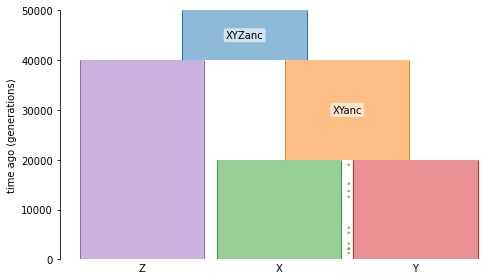

In [19]:
# Model with migration for X to Y
model_graph = three_pop_model(m_X_to_Y=1e-4)

demesdraw.tubes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography = msprime.Demography.from_demes(model_graph),
                          sequence_length = 10e6, recombination_rate = 2e-8, ploidy=1, random_seed=123)

#use function to get topology proportions
get_topology_proportions(ts)

Note the arrows added betwen X and Y showing unidirectional gene flow from X into Y.

We see that migration between X and Y **decreases** discordance. This is because it *increases* opportunities for coalescence between lineages from X and Y.

<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b>

What is the effect of migration between Z and X on the level of discordance?

What affect does migration between other population pairs have? (pay attention to the **relative proportion of the two discordant topologies**)

**Hint:** `demesdraw` sometimes displays the model in strange ways to fit the migration arrows in, so don't be alarmed.
    </div>


The proportion of genome with topology (2,(0,1)); is 0.2300552

The proportion of genome with topology (1,(0,2)); is 0.6708895

The proportion of genome with topology (0,(1,2)); is 0.0990553


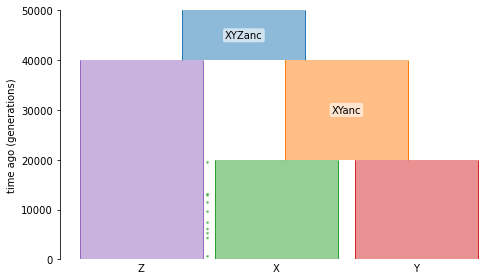

In [20]:
# SOLUTION:
# Model with migration for X to Z
model_graph = three_pop_model(m_X_to_Z=1e-4)

demesdraw.tubes(model_graph)

#simulate a treesequence
ts = msprime.sim_ancestry(samples={"X": 1, "Y": 1, "Z":1},
                          demography = msprime.Demography.from_demes(model_graph),
                          sequence_length = 10e6, recombination_rate = 2e-8, ploidy=1, random_seed=123)

#use function to get topology proportions
get_topology_proportions(ts)

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Which migrations caused assymetry in the number of discordant topologies?

What does it mean if the species topology is not teh most abundant type of genealogy?
    </div>

---
# 3. Investigating gene flow between Neanderthals and modern humans with real data

We will now turn to some real data from hominids and ask whether there is evidence of historical gene flow between Neanderthals and modern humans. We will be using the *D* statistic described in detail by [Durand et al. 2011](https://doi.org/10.1093/molbev/msr048).

Our data from **modern humans** comes from the 1000 Genomes Project, now hosted by the [IGSR: The International Genome Sample Resource](https://www.internationalgenome.org/).

Our data from **Neanderthals** comes from the [Altai Neanderthal Genome](https://www.eva.mpg.de/genetics/genome-projects/neandertal/) [[original publication](https://doi.org/10.1038/nature12886)].

Finally, in order to compute the *D* statistic, we need an outgroup to polarise our data.

We will use chimpanzee data from [the genome of a chimp called Clint](https://www.ncbi.nlm.nih.gov/assembly/GCF_002880755.1/).

All of this data has been aligned to the [human reference genome build 37](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.13/).

The archaic genomes were generated from ancient DNA, and therefore many CpG sites will have undergone post-mortem deamination to TpG. Therefore, all observed and potential CpG sites have been removed.

Finally, we are only analysing chromosome 1, for efficiency.


## 3.1 Introgression analysis using single haploid genomes ###

The simplest form of introgression analysis we can do uses just a single haploid genome from each of four populations.

* An outgroup (in this case, chimp assembly `panTro6`)
* A putative donor (P3) (in this case, Altai Neanderthal `AltaiNea`)
* A putative recipient (P2) (in this case a randomly chosen British individual `HG00096`)
* A control population (P1) (in this case a randomly chosen Nigerian of Yaruban ancestry `NA18488`)

We have downsampled the genomes to a single haploid base to simplify this analysis.

### 3.1.1 Loading the data from a VCF file

We start be defining the fields we are interested in in the VCF. In this case, just the sample names and genotypes. Then load the VCF using `allel`.

In [21]:
query_fields = ['samples', 'calldata/GT']

vcf_dict = allel.read_vcf('Prac6_data_2024/YRI1rndm_GBR1rndm_ALTrndm_chimp.chr1.SNP.vcf.gz', fields=query_fields)

Check the sample names.

In [22]:
print("Samples: ", vcf_dict['samples'])

Samples:  ['NA18488' 'HG00096' 'AltaiNea' 'panTro6']


We can look at the variants array to ensure it has been loaded correctly

In [23]:
print(vcf_dict['calldata/GT'])
vcf_dict['calldata/GT'].shape

[[[ 0 -1]
  [ 1 -1]
  [ 0 -1]
  [-1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 1 -1]
  [ 0 -1]
  [ 1 -1]
  [-1 -1]]

 ...

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]

 [[ 0 -1]
  [ 0 -1]
  [ 0 -1]
  [ 1 -1]]]


(393776, 4, 2)

`0` indicates the reference base and `1` indicates the alternate base. `-1` indicates missing data.

Note that the array has three dimensions:
1. Variants (393776)
2. Samples (4)
3. Alleles within each sample (2)

So there are two genotypes recorded at each site for each sample, but the second one is always 'missing' (`-1`). This is because the `read_vcf()` function of `allel` assumes diploid data, so reading a haploid file always results in one missing genotype.

To get around this we can simply ignore the second entry in the third dimension, thereby creating a 2-dimensional haplotype array.

In [24]:
#extract only first allele and convert to pandas dataframe
haplotypes = pd.DataFrame(vcf_dict['calldata/GT'][:,:,0])

#add labels
haplotypes.columns = ["Afr", "Eur", "Nea", "Chimp"]

haplotypes

,Afr,Eur,Nea,Chimp
0,0,1,0,-1
1,0,0,0,1
2,1,0,1,-1
3,0,0,-1,1
4,1,0,-1,0
...,...,...,...,...
393771,0,0,0,1
393772,0,0,0,1
393773,0,0,0,1
393774,0,0,0,1


### 3.1.2 Filtering to retain only useful sites

Note that there is still some missing data in the haplotype array. Both the chimp and neanderthal were aligned to the human reference genome, and sites at which alignment was unreliable are defined as missing (`-1`). This also happens when aligning genomes from the same species, but all missing data in the 1000 genomes data set has been "imputed".

The sites with missing data are not useful for our analysis, so we flag and remove these sites.

We also want to retain only biallelic sites. We will define these as sites at which only the human reference allele `0` and one alternate allele `1` is present. All sites with more than one alternate allele is present (alleles numbered `2` or more), will be excluded.

In [25]:
#identify biallelic sites and those without missing data
biallelic = haplotypes.max(axis=1) == 1
nomissing = haplotypes.min(axis=1) == 0

#subset the haplotypes
haplotypes = haplotypes[biallelic & nomissing]

haplotypes

,Afr,Eur,Nea,Chimp
1,0,0,0,1
5,0,0,1,0
6,0,0,0,1
7,0,0,0,1
8,0,0,0,1
...,...,...,...,...
393771,0,0,0,1
393772,0,0,0,1
393773,0,0,0,1
393774,0,0,0,1


### 3.1.3 Polarising the data

<div class="alert alert-block alert-info">
    <b>Popgen: Ancestral and Derived alleles</b>

For many applications it is useful to know which allele is <b>ancestral</b>, and which is <b>derived</b> (i.e. to "polarise" the mutations). For simulated data, this is known, but in real data we have to infer the ancestral state by examination of related taxa. For example, if there are two alleles segregating within humans and only one of these is observed in the champanzee, we can infer that the allele shared by the chimpanzee is ancestral. This implies that the derived allele arose within the human lineage after the divergence between human and chimp (~6 MYA). This inference is fairly safe because it is unlikely that there is much incomplete lineage sorting in the long branch ancestral to humans and Neanderthals over this timeframe.
    </div>

Currently, alleles are numbered according to whether they match the human **reference** genome (`0`) or **alternate** allele (`1`). This is ***not*** the same as **ancestral** and **derived** alleles.

To polarise our data, we will assume that the chimp always carries the ancestral allele, which we want to be represented by `0`. We therefore need to identify all sites at which the chimp allele is currently `1`, and 'flip' these, by converting `1` to `0` and `0` to `1` **in all individuals**.

In [26]:
sites_to_flip = haplotypes.Chimp == 1

#a new object to contain the polarised haplotypes
haplotypes_pol = haplotypes.copy()

#subtracting from 1 will convert 1s to 0s and 0s to 1s
haplotypes_pol[sites_to_flip] = 1 - haplotypes[sites_to_flip]

print(haplotypes_pol)

        Afr  Eur  Nea  Chimp
1         1    1    1      0
5         0    0    1      0
6         1    1    1      0
7         1    1    1      0
8         1    1    1      0
...     ...  ...  ...    ...
393771    1    1    1      0
393772    1    1    1      0
393773    1    1    1      0
393774    1    1    1      0
393775    1    1    1      0

[384107 rows x 4 columns]


### 3.1.3 ABBA BABA and D statistic

<div class="alert alert-block alert-info">
    <b>Popgen: ABBA BABA statistics</b>

Although we cannot observed genealogies directly from SNP data, we can use the "ABBA" and "BABA" site patterns as proxies for genealogical discordance. These are sites at which the Neanderthal shares a derived allele with either the European (ABBA) or African (BABA).

Under a simple bifurcating model without gene flow, the **relative** proportion of the two types of discordant topologies is **equal**, **regardless of population sizes and split times**. Therefore, the expected frequencies of ABBA and BABA mutation patterns is also equal under this null model.

In reality, recurrent mutation at the same site in different lineages can also give rise to ABBA and BABA patterns, but this should also lead to equivalent numbers of both, unless mutation rates are unequal between populations, which is [currently a controversial idea](https://doi.org/10.1098/rsos.191900). We will therefore assume that a deviation from equality in the number of ABBA and BABA sites is indicative of gene flow between Neanderthals and one of the modern human populations. The $D$ statistic provides a test for a deviation from this expected equilibrium.
    
$$ D = \frac{\sum{ABBA} - \sum{BABA}}{\sum{ABBA} + \sum{BABA}} $$
    
</div>

Given that the samples are already ordered \[African, European, Neanderthal, Chimp\], we can easliy identify ABBA sites as those at which the genotypes are `[0,1,1,0]` and BABA sites where the genotypes are `[1,0,1,0]`. The `numpy.all()` function ensures that all of genotypes match the pattern defined.

In [27]:
#creat a logical array indicating whether each site matches the ABBA or BABA pattern
ABBA = np.all(haplotypes_pol == [0,1,1,0], axis=1)
BABA = np.all(haplotypes_pol == [1,0,1,0], axis=1)

#Sum the logical array to get the total count
print("ABBA sites:", ABBA.sum())
print("BABA sites:", BABA.sum())

ABBA sites: 16479
BABA sites: 14873


<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b>

Write python code to compute and print the D statistic, which is the normalised difference between the total number of ABBA and BABA sites
    </div>

In [28]:
#SOLUTION:
D = (ABBA.sum() - BABA.sum()) / (ABBA.sum() + BABA.sum())

print("D:", D)

D: 0.05122480224547078


A positive *D* indicates excess of ABBA sites, consitent with **introgression between the Neanderthal and the European**. Below we will investigate the statistical significance of this D value, but first we will consider the proportion of introgression.

Note that *D* is not the same as the proportion of this individual's genome that is of Neanderthal origin. To estimate that parameter we need to take a slightly different approach.

### 3.1.4 Estimating *f*: the proportion of introgression


<div class="alert alert-block alert-info">
    <b>Popgen: Proportion of introgression</b>

To estimatate <i>f</i>, the proportion of this individual's genome that is of Neanderthal origin, we will use a common approach that compares the observed and expected excess of ABBA and BABA sites.

We will estimate the expected number of ABBA and BABA sites under the scenario that gene flow is complete, such that the <i>European is 100% Neanderthal</i>. A crude way to do this is to substitute the Neanderthal in for the European. In other words, we are calculating ABBA and BABA sites but with the Neanderthal genome used to represent *both* the Neanderthal and the European. If we had two Neanderthal genomes, we could have used one for each, but since we only have one, we will use it in both positions.

We compare this hypothetical excess of ABBA over BABA to our observed excess to estimate *f*.
    
$$ f = \frac{\sum{ABBA}[Afr, Eur, Nea, Chimp] - \sum{BABA}[Afr, Eur, Nea, Chimp] } {\sum{ABBA}[Afr, Nea, Nea, Chimp] - \sum{BABA}[Afr, Nea, Nea, Chimp]} $$

You might notice that, under this strict substitution scenario, BABA sites are all impossible because the Neanderthal and "European" (which is also represented by the same Neanderthal haplotype) cannot differ. Had we used two separate neanderthals, there would have been some BABA sites in the denominator.
</div>

The denominator for *f* estimation requires that we re-count ABBA and BABA sites but with the neanderthal substituted in place of the European.

In [29]:
#possible ABBAs are sites at which the African is 0, the Neanderthal is 1 and the chimp is 0
ABBA_possible = np.all(haplotypes_pol[["Afr","Nea","Nea","Chimp"]] == [0,1,1,0], axis=1)
BABA_possible = np.all(haplotypes_pol[["Afr","Nea","Nea","Chimp"]] == [1,0,1,0], axis=1)

f = (ABBA.sum() - BABA.sum()) / (ABBA_possible.sum() - BABA_possible.sum())

print("f:", f)

f: 0.018994677705499705


So our randomly chosen British individual has an estimated ~1.9% of neanderthal ancestry on chromosome 1.

<div class="alert alert-block alert-success">    
    <b>Class discussion:</b>

Because we had only one Neanderthal genome, we have made the assumption that under complete introgression, the European genome would be identical to this Neanderthal. What is problematic with this assumption, and what does it mean for our estimate of <i>f</i> ?

We have assumed directional introgression from neanderthal into European. What would it mean for our <i>f</i> estimate if gene flow had gone mostly the other way, from European into Neandertahl?
</div>

## 3.2 Introgression analysis using allele frequencies

Our analysis above made use of just a single haploid genome from each population. How could we extend this analysis to multiple diploid genomes? We could imagine sampling all possible sets of one haploid genome from each population and repeating the analysis, but this would be very tedious. Instead, we can make use of all of the data at once by using **allele frequencies**.

### 3.2.1 The 1000 genomes data set

For this full analysis we will use a more complete version of the 1000 genomes data set, comprising 26 populations.


|                African                                    | Code  |
|-----------------------------------------------------------|-------|
|   Gambian in Western Division – Mandinka                  |  GWD  |
|   Mende in Sierra Leone                                   |  MSL  |
|   Esan in Nigeria                                         |  ESN  |
|   Yoruba in Ibadan, Nigeria                               |  YRI  |
|   Luhya in Webuye, Kenya                                  |  LWK  |

|                American                                   | Code  |
|-----------------------------------------------------------|-------|
|   Mexican Ancestry in Los Angeles CA USA                  |  MXL  |
|   Colombian in Medellín, Colombia                         |  CLM  |
|   Peruvian in Lima Peru                                   |  PEL  |
|   Puerto Rican in Puerto Rico                             |  PUR  |
|   African Caribbean in Barbados                           |  ACB  |
|   African Ancestry in SW USA                              |  ASW  |

|                Asian                                      | Code  |
|-----------------------------------------------------------|-------|
|   Punjabi in Lahore, Pakistan                             |  PJL  |
|   Gujarati Indians in Houston, Texas, USA                 |  GIH  |
|   Indian Telugu in the U.K.                               |  ITU  |
|   Sri Lankan Tamil in the UK                              |  STU  |
|   Bengali in Bangladesh                                   |  BEB  |
|   Chinese Dai in Xishuangbanna, China                     |  CDX  |
|   Han Chinese in Beijing, China                           |  CHB  |
|   Han Chinese South                                       |  CHS  |
|   Japanese in Tokyo, Japan                                |  JPT  |
|   Kinh in Ho Chi Minh City, Vietnam                       |  KHV  |

|                European                                   | Code  |
|-----------------------------------------------------------|-------|
|   Finnish in Finland                                      |  FIN  |
|   British From England and Scotland                       |  GBR  |
|   Iberian Populations in Spain                            |  IBS  |
|   Toscani in Italia                                       |  TSI  |
|   Utah residents with north and west European ancestry    |  CEU  |

This can allow us to test for introgression in multiple locations. Individuals representing each population were asked to confirm that they have four grandparents all from that region/community. We can predict that some of these populations have experienced significant admixture in recent history (e.g. people with African ancestry in USA), whereas others may have had less recent admixture with other modern human populations (e.g. people from Finland).


### 3.2.2 Import allele frequencies for each population

This dataset consists of all 26 populations in the 1000 Genomes dataset, as well as the Neanderthal, Chimp and a [Denisovan](https://www.eva.mpg.de/genetics/genome-projects/denisova/) [[original publication](https://doi.org/10.1126/science.1224344)]. To save time, we have pre-computed the **frequency of the derived allele** for each population. See Appendix A1 for complete code on how we got from VCF to derived allele frequency.

Load the allele frequencies into a pandas dataframe.

In [30]:
#import allele frequencies
allele_freqs = pd.read_csv("Prac6_data_2024/1000G_ALT_DEN_chimp.chr1.freqs.csv.gz")

allele_freqs

,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,MXL,PEL,PJL,PUR,STU,TSI,YRI,NEA,DEN,CHIMP
0,0.00,0.00,0.05,0.0,0.20,0.0,0.0,0.10,0.00,0.05,...,0.00,0.0,0.05,0.10,0.0,0.00,0.00,0.0,0.0,0.0
1,0.00,0.00,0.30,0.0,0.35,0.0,0.0,0.25,0.00,0.30,...,0.15,0.0,0.30,0.20,0.2,0.15,0.00,0.0,0.0,NaN
2,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.05,0.00,0.0,0.00,0.00,0.0,0.0,0.0
3,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.10,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.05,0.00,0.0,0.0,0.0
4,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962771,0.05,0.05,0.00,0.0,0.00,0.0,0.0,0.00,0.15,0.00,...,0.00,0.0,0.00,0.05,0.0,0.00,0.25,0.0,0.0,0.0
1962772,1.00,1.00,1.00,1.0,1.00,1.0,1.0,1.00,1.00,1.00,...,1.00,1.0,1.00,1.00,1.0,1.00,1.00,1.0,1.0,0.0
1962773,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0
1962774,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0


### 3.2.2 ABBA BABA analysis using allele frequencies


<div class="alert alert-block alert-info">
    <b>Popgen: ABBA BABA statistics from allele frequencies</b>

We can compute the probability of an ABBA or BABA using allele frequencies.

$$ Pr[ABBA] = (1-p1) * p2 * p3 $$
$$ Pr[BABA] = p1 * (1-p2) * p3 $$

Where $p1$, $p2$, $p3$ are the derived allele frequencies in the African, European, Neanderthal, respectively.

At a site where the European and neanderthal are fixed for the derived allele, and it is absent in Africans and Chimps, this will give $Pr[ABBA] = 1$. At sites where allele frequencies are intermediate, the value will range between 0 and 1.

Note that the Chimp allele frequency is not icnluded here. This is because the chimp was used to infer which is the ancestral allele, so it will alwyas have a derived allele frequency of 0.

</div>

To compute ABBA and BABA counts and D statistics, we will write functions that use the allele frequencies.

In [31]:
#function to compute ABBA and BABA per site and sum
#We use nansum because some of the values are nan due to missing data
def get_ABBA(P1_freqs, P2_freqs, P3_freqs):
    return np.nansum((1 - P1_freqs) * P2_freqs * P3_freqs)

<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 1 [1 point]:</b>

Write a function called <code>get_BABA()</code> similar to the <code>get_ABBA()</code> function above.
    </div>

In [32]:
#SOLUTION:
def get_BABA(P1_freqs, P2_freqs, P3_freqs):
    return np.nansum(P1_freqs * (1-P2_freqs) * P3_freqs)

Test these new functions. Here we will use CEU as our European population. This consists of [Utah residents with ancestry from northern and western Europe](https://catalog.coriell.org/1/NIGMS/Collections/CEPH-Resources), and is one of the best studied populations in human genetics.

In [33]:
#define the populations to use
P1, P2, P3 = "YRI", "CEU", "NEA"

print("ABBA:", get_ABBA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3]))
print("BABA:", get_BABA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3]))

ABBA: 16854.626249999987
BABA: 15592.976249999987


<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 2 [2 points]:</b>

Write a function called <code>get_D()</code> that takes the frequencies as inputs and uses the <code>get_ABBA()</code> and <code>get_BABA()</code> functions, and returns the D statistic.
    </div>

In [34]:
#SOLUTION:
def get_D(P1_freqs, P2_freqs, P3_freqs):
    ABBAsum = get_ABBA(P1_freqs, P2_freqs, P3_freqs)
    BABAsum = get_BABA(P1_freqs, P2_freqs, P3_freqs)
    return (ABBAsum - BABAsum) / (ABBAsum + BABAsum)

We also want to write a function to estimate the proportion of the genome that has been exchanged (*f*). Once again, we do this by assuming that introgression would lead to replacement of the European population by the Neanderthal. We will therefore calculate the expected number of possible ABBA and BABA sites when the allele frequencies in are replaced by those in the Neanderthal.

<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 3 [3 points]:</b>

Write a function called <code>get_f()</code> that takes the frequencies as inputs and uses the <code>get_ABBA()</code> and <code>get_BABA()</code> functions, and returns the estimated f.
    </div>

In [35]:
#SOLUTION:
def get_f(P1_freqs, P2_freqs, P3_freqs):
    ABBAsum = get_ABBA(P1_freqs, P2_freqs, P3_freqs)
    BABAsum = get_BABA(P1_freqs, P2_freqs, P3_freqs)
    
    ABBA_possible_sum = get_ABBA(P1_freqs, P3_freqs, P3_freqs) #possible ABBAs when P2 becomes P3
    BABA_possible_sum = get_BABA(P1_freqs, P3_freqs, P3_freqs) #possible BABAs when P2 becomes P3
    
    return (ABBAsum - BABAsum) / (ABBA_possible_sum - BABA_possible_sum)

Now we have all the pieces in place to compute *D* and *f* using any set of populatios we desire. If your functions work correctly, this next code block should output reasonable D and f values.

In [36]:
#define populations to use
P1, P2, P3 = "YRI", "CEU", "NEA"

#Get D
print("D:", get_D(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3]))

#Get f
print("f:", get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3]))


D: 0.03888268786576761
f: 0.015795448534587638


<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 4 [3 points]:</b>

Re-calculate the admixture proportion (f) for different P2 populations (always keeping P1 as YRI). What is the maximum and minimum admixture proportion in European populations? Asian populations? American populations? [3]
    
<b>HINT:</b> You can use a `for` loop, to set a differnt P2 population each time and recompute f using your `get_f` function.

</div>

In [37]:
#SOLUTION:

European_populations = ["FIN", "GBR", "IBS", "TSI", "CEU"]
Asian_populations = ["PJL", "GIH", "ITU", "STU", "BEB", "CDX", "CHB", "CHS", "JPT", "KHV"]
American_populations = ["MXL", "CLM", "PEL", "PUR", "ASW", "ACB"]

print("\n Introgression into Europeans.")
for P2 in European_populations:
    f = get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3])
    print(f"f for {P2} is {f}.")

print("\n Introgression into Asians.")
for P2 in Asian_populations:
    f = get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3])
    print(f"f for {P2} is {f}.")

print("\n Introgression into Americans.")
for P2 in American_populations:
    f = get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3])
    print(f"f for {P2} is {f}.")


 Introgression into Europeans.
f for FIN is 0.014842701232655917.
f for GBR is 0.01667432975134966.
f for IBS is 0.014392931892026634.
f for TSI is 0.012860523616646385.
f for CEU is 0.015795448534587638.

 Introgression into Asians.
f for PJL is 0.021676566078377802.
f for GIH is 0.018149147519648735.
f for ITU is 0.021941044222310694.
f for STU is 0.01731690209394715.
f for BEB is 0.019366372965513665.
f for CDX is 0.02400553870442014.
f for CHB is 0.02356703707169804.
f for CHS is 0.0201353940301806.
f for JPT is 0.023456863927716436.
f for KHV is 0.021105355885859416.

 Introgression into Americans.
f for MXL is 0.017641787671938004.
f for CLM is 0.01838107450740554.
f for PEL is 0.02018328178878615.
f for PUR is 0.018834286758784402.
f for ASW is 0.0037499557898958953.
f for ACB is -0.000361192636803258.


<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 5 [3 points]:</b>

a. The variance in f in Europe and Asia is fairly low. Explain why this is informative about the timing of gene flow from Neanderthals? [3]

b. Some American populations have high levels of Neanderthal introgression and some have very low, why? [3]

</div>

### Answer for Assessed Exercise 5:

a. Low variance in admixture proportions among populations is consistent with an early admixture event,
soon after the out-of-africa event. This way, all descendent populations of modern humans out of Africa inherited similar levels of Neanderthal ancestry.

b. Most are of European/Asian origin, but ASW and ACB are of African origin,and established in the Americas much more recently, and therefore did not inherit the Neanderthal introgression.


## 3.3 Parametric bootstrap using simulated data

<div class="alert alert-block alert-info">
    <b>Bootstrapping the D statistic</b>

Bootstrapping provides a means to assess the statistical significance of our results.

1. A non-parametric bootstrap for the D statistic is usually achieved using a block jackknife approach to account for non-independence among SNPs, but it is difficult to be sure that non-independence is adequately accounted for.
2. A parametric bootstrap can be achieved by simulating data under a model without gene flow to assess the <b>likelihood of observing the empirical results by chance alone</b>.

We will implement a parametric bootstrap by simulating data under a realistic model. We will use the demographic model based on that inferred by [Jacobs et al.](https://doi.org/10.1016/j.cell.2019.02.035), which inludes the following well-supported events:
* Neanderthals left Africa around 500,000 years ago.
* Modern humans alive today descend from a population that remained in Africa until about 50,000 years ago.
* The out-of-africa migration that gave rise to Europeans and Asians involved a short but strong bottleneck.
* Soon after the out-of-Africa event, a pulse of admixture occurred from Neanderhals into out-of-africa humans.
* Gene flow continued between human populations.
</div>

### 3.3.1 A simulation model for hominin ancestry

Instead of defining this model ourselves, we will load it from a text file in .yaml format, interpretable by the `demes` package.

<AxesSubplot:ylabel='time ago (generations)'>

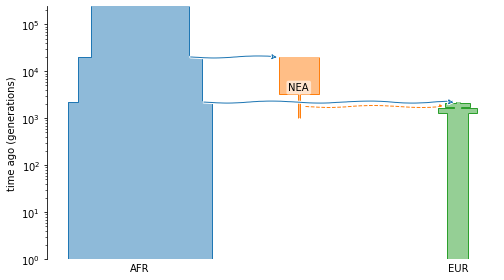

In [38]:
model_graph = demes.load("Prac6_data_2024/HomSap_based_on_Jacobs.yaml") #model with archaic gene flow

demesdraw.tubes(model_graph, log_time=True)

We want to test the hypothesis of gene flow between archaics and modern humans. For our parametric bootstrap, we therefore want to use a **null model that does not include any gene flow**. We will use a modified version of the model above with the admixture 'pulse' from Neanderthals removed.

<AxesSubplot:ylabel='time ago (generations)'>

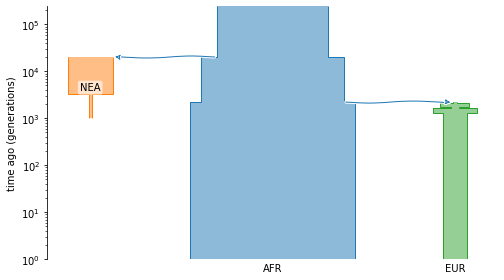

In [39]:
model_graph = demes.load("Prac6_data_2024/HomSap_based_on_Jacobs_no_introgression.yaml") # model without archaic gene flow

demesdraw.tubes(model_graph, log_time=True)

### 3.3.2. Bootstrapping the D statistic

To test whether our D statistic differs significantly from zero, we will perform a parametric bootstrap by simulating a D statistic hundreds or thousands of times under this null model and comparing these values to our observed value. This involves the following steps:
1. Simulate a treesequence under the null model (using the human chromosome 1 recombination map to keep things accurate
2. Add mutations into the treesequence under a realistic mutational model
3. Extract a genotye matrix
4. Compute allele frequencies and from these the D statistic.
5. Repeat steps 1-4 many times and compare the values to the observed value

Unfortunately, each one of these simulations takes a few hours, so we will not be running through these steps now. See Appendix A2 for complete code for simulation and computation of D for human chromosome 1 under the model above.

For this practical we will simply import 200 simulated D statistics from simulations that have been run for you and compare these to the observed value. These are saved as a text file with three columns: ABBA, BABA and D.

In [40]:
#import simulated values
sim_D = np.loadtxt("Prac6_data_2024/sim_D_200.txt")

We can assess visually how our observed D value compares to those simulated under the null model.

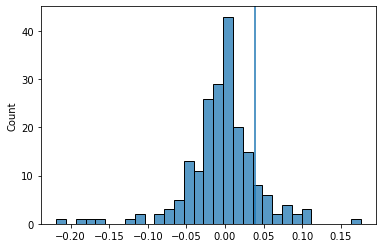

In [41]:
#define populations to use
P1, P2, P3 = "YRI", "CEU", "NEA"
D = get_D(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3])

sns.histplot(sim_D)
plt.axvline(D, 0,200)

<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 6 [2 points]:</b>

Calculate the p-value for the test of whether our D value is **greater** than expected through chance alone under the null model. The **one-tailed** p-value is the proportion of simulated D values that are greater than or equal to the observed value.
    
**Hint:** Use the `>=` operator to make a logical array stating whether each simulated value is larger (`True`) or not larger (`False`) than the observed D. You can then use th `.sum()` function directly on the logical array (because it is equivalent to an array of zeros and ones), and this returns the number of `True` values. 
</div>

In [42]:
#SOLUTION:

greater = sim_D >= D

p = greater.sum()/len(sim_D)

print("p-value:", p)

p-value: 0.11


<div class="alert alert-block alert-success">    
    <b>Assessed Exercise 7 [6 points]:</b>

Given the observed D and f satisics, and the bootstrapping results, evaluate the evidence for introgression between Neanderthals and Europeans. Assuming the chromosome analysed is representative of the admixture proportion of the genome as a whole, would repeating this analysis and bootstrap at the scale of the whole genome change the statistical significance? Why?

</div>

### Answer for assessed exercise 7:
There is a signal of introgression, but it is not significant according to a p-value cutoff of 0.05.
Adding more of the genome will likely increase significance because the larger amount of data will reduce the variance in D values generated in simulations.

# -------------- END OF PRACTICAL 6 -----------------

---
# Appendix A1. Extracting derived allele frequencies from a multi-sample VCF

Above we used allelel frequencies to compute ABBA BABA statistics. This appendix covers the steps to obtain derived allele frequencies from a multi-sample VCF using the code below. This file contains 10 individuals each from 26 1000 Genomes project populations, one Neanderthal, one Denisovan and one Chimpanzee.

First load the VCF file.

In [ ]:
query_fields = ['samples', 'calldata/GT']
vcf_dict = allel.read_vcf('Prac6_data_2024/1000Gsubset_ALT_DEN_chimp.chr1.SNP.vcf.gz', fields=query_fields)

### A1.1 Generating and filtering the genotype array

We will convert the data into a `allel.GeotypeArray`object, to take advantage of the inbuilt function to help us compute allele frequencies.

In [ ]:
genotypes = allel.GenotypeArray(vcf_dict['calldata/GT'])

genotypes

Note that there are now 263 samples: 260 modern humans, 1 Neanderthal, 1 Denisovan and 1 chimp (that's Clint!).

As before, we only want biallelic sites. Although the genotypes are displayed as `0/0` or `./.` (for missing data). The underlying data still consists of the values `0` for reference allele, `1`,`2` etc for alternate and `-1` for missing. We can therefore once again take those sites at which the highest alternate allele code is `1` as niallelic sites. We have to use the `max()` function twice: first to get the maximum value per site, and then to get the maximum value in the two alleles carried by each individual.


In [ ]:
#biallelic sites are sites at which the maximum genotype is 1
biallelic = genotypes.max(axis=1).max(axis=1) == 1

genotypes = genotypes[np.where(biallelic)]

genotypes.n_variants

### A1.2 Storing population info for each sample

Each population in the 1000 Genomes data is represented by 10 samples. To count alleles, `allel` needs a dictionary giving the **index positions** for each population (i.e. which columns in the GenotypeArray). For example individuals from population `GBR` occupy columns 100-109. The 1000 genomes sample names are uninformative, so we load an additional file that tells us which population each sample comes from, and then retrieve its index position in the vcf.

<div class="alert alert-block alert-warning">
    <b>Python recipe: defaultdict</b> 

A <code>defaultdict</code> is a dictionary with a useful twist. When you try to access a key that is not yet in the dictionary, it automatically adds that key, and along with a corresponding default value of your choosing. For example <code>defaultdict(list)</code> creates a defaultdict that will create an empty list for each new key.

**Why is this useful?** Below we will read through a text file line by line, which gives sample names and the population the belong to. For each sample, we will add its index position to a list depending on which population it comes from. These lists are stored in a dictionary. But what happens if we encounter a sample from a population we have not yet seen? We would normally need to add a *new key* to the dictionary. `defaultdict` avoids this problem. When we ask it to add the current sample to the appropriate population, if the population is not yet a key in the dictionary, it will first be added along with an empty list as its value, and then the sample will be added to that list as requested. This way, we avoid having to check that a key is present in the dictionary before modifying its corresponding value. </div>

In [ ]:
#A defaultdict to store the sample indices for each population
pop_idx_dict = defaultdict(list)

#extract sample list from vcf header. We use this to find the index (position) of each sample from each population
vcf_samples = list(vcf_dict["samples"])

#now run through the sample populations file to assign individuals to each population
with open("Prac6_data_2024/1000Gsubset_ALT_DEN_chimp.pops.txt", "rt") as popsfile:
    for line in popsfile:
        sample, population = line.split()
        idx = vcf_samples.index(sample)
        pop_idx_dict[population].append(idx) 

#we can now get a list of populations, which are represented by the keys of the dictionay
pops = tuple(pop_idx_dict.keys())

#Print the new dictionary to check the sample indices
for pop in pops:
    print(pop, pop_idx_dict[pop])


See that the 1000 Genomes populations each consist of 10 samples while the Neanderthal, Denisovan and Chimp each have 1.

### A1.3 Allele frequencies

We will use allele frequencies in each population for the ABBA BABA computation.

First we will count the total number of observed reference (`0`) and alternate (`1`) alleles in each population. For this, we use the population index dictionary we made above.

In [ ]:
allele_counts = genotypes.count_alleles_subpops(pop_idx_dict)

#Inspect some examples
for pop in ["GBR", "NEA", "CHIMP"]:
    print(pop)
    print(allele_counts[pop])

Here the first number for each site is the number of copies of the reference allele, and the second number is the number of copies of the alternate allele.

Note how the sum of allele counts for each population is the total number of haplotypes in that population. The chimp data has just one haplotype because it was haploid (it was made by aligning a haploid referecne genome to the human genome). Sites at which there is missing data are those where the number of reference and alternate alleles is zero.

Once again, we now need to polarize our data: instead of counts of reference and alternate, we want counts of `ancestral` and `derived` alleles. We will again use the chimp to achive this, under the assumption that that the allele observed in the chimp (which is haploid) is always the ancestral allele. Therefore any site at which the chimp has the alternate base needs to be 'flipped'. At these sites, we will swap the counts of reference and alternate so that they match ancestral and derived.

In [ ]:
#identify sites where flipping is necessary
sites_to_flip = np.where(np.all(allele_counts["CHIMP"] == [0,1], axis=1))

# for each population, flip the sites by reversing the allele counts
for pop in pops:
    allele_counts[pop][sites_to_flip] = allele_counts[pop][sites_to_flip][:,::-1]

Finally, we convert the allele counts to allele frequencies (i.e. a value between 0 and 1 giving the proportion of the population sample made up of derived alleles. We will save these in a pandas dataframe for eacy export to a text file.

In [ ]:
#make an empty dataframe
allele_freqs = pd.DataFrame()

#divide the derived allel count by the total allele count
for pop in pops:
    allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)

allele_freqs

Don't worry about the warning. This is because some sites have missing data (no alleles observed) so we are dividing by zero. This is not a problem as these sites just get a frequency value `nan`, and will be excluded from any calculation.

Write allele frequencies to a text file, with gzip compression to save space. `index=False` tells pandas not to add a first column giving line numbers.

In [ ]:
allele_freqs.to_csv("Prac6_data_2024/1000G_ALT_DEN_chimp.chr1.freqs.csv.gz", index=False, compression="gzip")

---
## Appendix A2: Computing the D statistic from simulated data

Because the bootstrapping simulations take a long time, we ran them for you. The text below walks through the steps of how these simulations were done.


### A2.1 Load the null demographic model

First we load the demographic model from the .yaml file and convert this model into an `msprime.Dempgraphy` object.

In [ ]:
model_graph = demes.load("Prac6_data_2024/HomSap_based_on_Jacobs_no_introgression.yaml") # model without archaic gene flow

demography = msprime.Demography.from_demes(model_graph)

### A2.2 Load the recombination map for human chromosome 1

Since we have used chromosome 1 for our analysis, we want our simulation to have the same chromosome length and recombination landscape. We therefore import a published genetic map for human chromosome 1 using `msprime`.

In [ ]:
recombination_map = msprime.RateMap.read_hapmap("Prac6_data_2024/genetic_map_GRCh37_chr1.txt.gz")

### A2.3 Simulate treesequence and mutations for chr1

We can now simulate the treesequence, ensuring that we sample 10 individuals each from the YRI (African) and CEU (European) populations, and one Altai Neanderthal.

**NOTE: this large simulation will take a few hours to run**

In [ ]:
ts = msprime.sim_ancestry(samples={"YRI": 10, "CEU": 10, "NeaA":1},
                          demography=demography, recombination_rate = recombination_map,
                          ploidy=2, record_provenance=False) #record_provenance=False just saves a little bit of memory

Now instead of assessing the genealogies directly as we did earlier, we want to extract mutations so that we can identify ABBA and BABA sites. Currently our treesequence does not contain any mutations, so we need to add these using a second simulation step. First we define the mutation model. We will use the [HKY model](https://en.wikipedia.org/wiki/Models_of_DNA_evolution#HKY85_model_(Hasegawa,_Kishino_and_Yano_1985)), which has different rates for transistions and transversions, as well as different frequencies of purines and pyrimidines. This affects the probability of recurrent mutation at the same site, and is therefore necessary for a realistic simulation of ABBA and BABA sites.

In [ ]:
#HKY model with transition/transversion ratio of 2.1 and GC content of 0.6.
mutation_model = msprime.HKY(kappa=2.1, equilibrium_frequencies=[0.3, 0.2, 0.2, 0.3])

Now simulate mutations onto the treesequence

In [ ]:
mts = msprime.sim_mutations(ts, rate=1e-8, model=mutation_model)

### A2.4 Genotype matrix from treesequence

We can extract a geotype matrix and generate a allel.HaplotypeArray object. We do not use allel. GenotypeArray because the simulation generates haploid sequences (2 haplotypes per diploid individual in the simulation).

In [ ]:
haplotypes = allel.HaplotypeArray(mts.genotype_matrix())

haplotypes

As we did before, we can ratain only biallelic sites. Since this is a 2-dimensional haplotype array, we just need to take the maximum of the first dimension and confim that it is 1.

In [ ]:
biallelic = haplotypes.max(axis=1) == 1

haplotypes = haplotypes[np.where(biallelic)]

### A2.5 Allele frequencies

To calculate allele counts using `allel`, we need a dictionary giving the indices of each population in the haploype matrix. Since we sampled 10 diplioids from YRI. These represent indices 0 to 19. Likewise CEU is at indices 20 to 39. We sampled just one Neanderthal, which has indices 40 and 41.

In [ ]:
pop_idx_dict = {"YRI": list(range(0,20)), "CEU": list(range(20,40)), "NEA": list(range(40,42))}

allele_counts = haplotypes.count_alleles_subpops(pop_idx_dict)

allele_counts

Now compute the derived allele frequency by dividing the second column in the allele counts by the total for each population.

In [ ]:
#make an empty dataframe
allele_freqs = pd.DataFrame()

#divide the derived allel count by the total allele count
for pop in ["YRI", "CEU", "NEA"]:
    allele_freqs[pop] = allele_counts[pop][:,1] / allele_counts[pop].sum(axis=1)

allele_freqs

### A2.6 ABBA BABA statistics

Finally, we can calculate ABBA, BABA, D and f from the allele frequencies. Although we did not simulate the outgroup, we know that it should have the ancestral allele at all sites, so its derived allele frequency can simply be set to 0 and this will be applied to all sites.

In [ ]:
#define populations to use
P1, P2, P3 = "YRI", "CEU", "NEA"

#ABBA and BABA
print("ABBA:", get_ABBA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))
print("BABA:", get_BABA(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

#Get D directly
print("D:", get_D(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

#Get f
print("f:", get_f(allele_freqs[P1], allele_freqs[P2], allele_freqs[P3], 0))

For the full bootstrap, the above procedure was repeated 200 times to produce a null distribution of D values for chromosome 1.